In [1]:
#Dépendances

#Math
import numpy as np
import numpy.random as rnd
import scipy.special as special
import scipy.stats as st

# Plot
import matplotlib.pyplot as plt

# 
import time

# Loi de Benford et fraude comptable

La loi de Benford modélise un phénomène étrange : dans la plupart des données chiffrées que nous côtoyons, le premier chiffre significatif est bien plus souvent un 1 qu’un 9. Ce texte présente quelques propriétés de cette loi, ainsi qu’une utilisation possible pour la détection de fraudes comptables.

**Introduction** : Dans un premier temps nous présenterons la loi de Benford. Dans un deuxième temps nous présenterons les aspects théorique du test du $\chi^{2}$, puis les aspects pratiques pour détecter des fraudes chez 8 vendeurs. Afin de compléter cette étude nous présenterons une autre méthode basée sur le test de Kolmogorov. La question sous jacente tout au long de cette présentation est : Quel sont les vendus parmi les vendeurs ? C'est à dire qui me piquent de l'argent parmis mes 8 vendeurs ?

## 1 Loi de Benford et équirépartition


Pour définir plus précisément la loi de Benford, on utilise l'écriture scientifique des réels :
pour tout $s \in \mathbb{R}_{+}, s=t .10^{n}$, avec $n \in \mathbb{Z}$ et $t \in[1,10[.$ Dans toute la suite, log désigne le logarithme en base dix.

**Définition 1**. Une variable aléatoire $T$ à valeurs dans $\mathbb{R}_{+}$ suit la loi de Benford si $\log T \sim$ $\mathcal{U}(0,1)$
La variable $T$ est en réalité à valeurs dans $[1,10[.$ C'est une variable continue, de densité
$$
f_{T}(x)=\frac{1}{x \ln 10} 1_{[1,10]}(x)
$$
Le premier chiffre significatif de $T$ est sa partie entière. Si $T$ suit la loi de Benford, alors
$$
\mathbb{P}(\lfloor T\rfloor=d)=\log \left(1+\frac{1}{d}\right) 
$$
pour $d \in \{1,...,9\}$ noté $(1)$

On peut calculer simplement la fonction de répartion de la loi de Benford grâce à la densité :
$$
\mathbb{P}(T \le t) = \int_{1}^{t} f_{T}(x) dx = {\ln(t) \over \ln(10)}
$$
pour $t \in [1;10]$, 0 si $t \le 1$ et $1$ si $t \ge 10$.

Ce qui nous donne une preuve de l'assertion 
$$
\mathbb{P}(\lfloor T\rfloor=d)=\log \left(1+\frac{1}{d}\right) 
$$
pour $d \in \{1,...,9\}$

En effet 
$$
\mathbb{P}(\lfloor T\rfloor=d)= \mathbb{P}(d \le T < d+1) = {\ln(d+1)-\ln(d) \over \ln(10)}=\log \left(1+\frac{1}{d}\right) 
$$

In [189]:
def Benford_rep(t):
    """
    Return : Calcul la fonciton de répartition de la loi de T en t
    """
    if t<1:
        return 0
    else:
        if t>10:
            return 1
        else: 
            return np.log(t)/np.log(10)

## 2 Recherche d’une fraude et tests statistiques


Une entreprise emploie huit vendeurs. Le chef d’entreprise soupçonne que certains d’entre eux détournent de l’argent. Il voudrait en avoir le cœur net et surtout identifier les vendeurs concernés. Il dispose pour chacun des vendeurs d’un rapport comptable comportant les montants des transactions effectuées.

Des travaux de recherche en comptabilité (notamment par Nigrini) ont montré que les données normales de comptabilité suivent la loi de Benford. Le chef d’entreprise envisage d’effectuer un test d’adéquation des rapports comptables de ses vendeurs avec la loi de Benford. Pour cela, il extrait des rapports comptables les mantisses des montants des transactions, c’est-à-dire la partie $t$ dans l’écriture $s = t.10^{n}$ en notation scientifique du réel positif $s$.

In [9]:
# Fichier contenant les mantisses des vendeurs 1 à 8
V1=np.loadtxt('vendeur1')
V2=np.loadtxt('vendeur2')
V3=np.loadtxt('vendeur3')
V4=np.loadtxt('vendeur4')
V5=np.loadtxt('vendeur5')
V6=np.loadtxt('vendeur6')
V7=np.loadtxt('vendeur7')
V8=np.loadtxt('vendeur8')

In [53]:
# test 
print(V1)
print(V1.shape)
print(V1.size)
V = [V1,V2,V3,V4,V5,V6,V7,V8]
print(V[0])
print(V[0].size)

[6.686542 3.455919 1.232509 ... 1.531963 1.402977 8.944798]
(10000,)
10000
[6.686542 3.455919 1.232509 ... 1.531963 1.402977 8.944798]
10000


### 2.0 Test du $\chi^{2}$

L'observation est formée par un $n$ echantillon $X=\left(X_{1}, \ldots, X_{n}\right)$, dont chacune des variables prend ses valeurs dans un ensemble discret $\mathcal{X}=\left\{x_{1}, \ldots, x_{d}\right\}$. On note $p=\left(p_{1}, \ldots, p_{d}\right)$ la loi commune des $X_{t}:$ pour tout $t \in\{1, \ldots, n\}$ et tout $i \in\{1, \ldots, d\}$,
$$
\mathbb{P}\left\{X_{t}=x_{i}\right\}=p_{i}
$$
Ou se donne une loi de référence $p^{ref }$ sur $\mathcal{X}$ de support plein, ie, $d$ réels strictement
positif $p^{ref}_{1},...,p^{ref}_{d}$ tels que $p^{ref}_{1}+...+p^{ref}_{d} = 1$. On désire tester si les $X_{t}$ ont pour loi commune $p^{ref}$, c'est-à-dire effectuer un test des hypothèses
$$
H_{0}: p=p^{ref} \quad \text { contre } \quad H_{1}: p \neq p^{ref} \text { . }
$$
Elles se réécrivent évidemment comme
$$
H_{0}: \text { pour tout } i \in\{1, \ldots, d\}, \quad p_{i}=p_{i}^{\text {ref }}
$$
$$
\text{contre}
$$
$$
H_{1} : \text{il existe } i \in\{1, \ldots, d\} \text{ tel que } p_{i} \neq p_{i}^{r_{i}} \text{ .}
$$
Ou utilise la méthode des moments pour estimer $p:$ pour tout $i \in\{1, \ldots, d\}$, les
$$
\widehat{p}_{i, n}=\frac{N_{i, n}}{n} \quad \text { où } \quad N_{i, n}=\sum_{t=1}^{n} \mathbb{I}_{\left\{X_{t}=x_{i}\right\}}
$$
sont des estimateurs fortement consistants (par la loi forte des grands nombres), et sans biais (par définition) des $p_{i}$ 

Ainsi si $H_{0}$ est vraie, il y a tout lieu de penser que $\hat{p}_{n}=\left(\widehat{p}_{1, n} \ldots ., \hat{p}_{d, n}\right)$ est proche de $p^{ref} = (p^{ref}_{1},...,p^{ref}_{d})$ lorsque $n$ est grand.

La statistique naturelle du test consiste donc en une mesure de l'écart entre $\hat{p}_{n}$ et $p^{ref}$. Pour avoir des bonnes propriétés on ne considère pas la distance euclidienne entre ces deux probabilités, mais plutôt la pseudo-distance du $\chi^{2}$ ou statistique de Pearson
$$
D_{n}^{2} = n \sum_{i=1}^{d} { (\hat{p}_{i,n} - p_{i}^{ref})^{2} \over p_{i}^{ref} } = \sum_{i=1}^{d} { (N_{i,n} -n p_{i}^{ref})^{2} \over  n p_{i}^{ref} } 
$$

**Théorème** : La statistique de Pearson $D_{n}^{2}\left(\hat{p}_{n}, p^{ref}\right)$ admet les comportements limites suivants, lorsque $n$ tend vers $+\infty$ : 
- Sous $H_{0}: p=p^{ref}$, on a la convergence en loi $: D_{n}^{2}\left(\hat{p}_{n}, p^{ref}\right) \rightarrow \chi^{2}(d-1) ;$
- Sous $H_{1}: p \neq p^{ref}$, on a la divergence : $D_{n}^{2}\left(\hat{p}_{n}, p^{ref}\right) \rightarrow +\infty$ p.s.

**Preuve** On commence par le comportement sous $H_{0}$. Pour tout $t \in\{1, \ldots, n\}$, on définit les variables aléatoires
$$
Z_{t} = \left( { \mathbb{1}_{X_{t} = x_{1}} - p_{1}^{ref} \over \sqrt{p_{1}^{ref}} }, \ldots,  { \mathbb{1}_{X_{t} = x_{d}} - p_{d}^{ref} \over \sqrt{p_{d}^{ref}} } \right)
$$
On en déduit la moyenne empirique 
$$
\bar{Z}_{n} = {1 \over n } \sum_{t=1}^{n} Z_{t} = \left( { \hat{p}_{1,n} - p_{1}^{ref} \over \sqrt{p_{1}^{ref}} } , \ldots, { \hat{p}_{1,n} - p_{d}^{ref} \over \sqrt{p_{d}^{ref}} }  \right)
$$

Montrons que l'on peut appliquer le théorème de la limite centrale multi-dimensionnel :
- Les $Z_{1}, \ldots, Z_{n}$ sont indépendantes et identiquement distribuées selon une loi admetant un moment d'ordre deux, d'espérance le vecteur nul et de matrice de variance-covariance $\Gamma$ définie par 
$$
\Gamma_{i,i} = \text{Var}\left( {  \mathbb{1}_{X_{1} = x_{i}} - p_{i}^{ref} \over \sqrt{p_{i}^{ref}} } \right)  = {p_{i}^{ref}1(1-p_{i}^{ref} )\over p_{i}^{ref}} = 1- p_{i}^{ref}
$$ 
$$
\Gamma_{i,j} =  \text{Cov}\left( {  \mathbb{1}_{X_{1} = x_{i}} - p_{i}^{ref} \over \sqrt{p_{i}^{ref}} }, {  \mathbb{1}_{X_{1} = x_{j}} - p_{j}^{ref} \over \sqrt{p_{j}^{ref}} } \right)  = - \sqrt{p_{i}^{ref}} \sqrt{p_{j}^{ref}}
$$
Car les variables aléatoires $ \mathbb{1}_{X_{i} = x_{j}}$ pour $i \in \{1,...,n)$ sont indépendante de loi de Bernouilli $\mathcal{B}(p_{j}^{ref})$ quelque soit $j \in \{1,...n\}$


Pour tous $i, j \in\{1, \ldots, d\}$ et $i \neq j$. On note pour la suite $\sqrt{p}=\left(\sqrt{p}_{1}, \ldots \cdot \sqrt{p_{d}}\right)$. Par le théorème de la limite centrale multi-dimensionnel, on a ainsi la convergence en loi, lorsque $n$ tend vers $+\infty$ :
$$
\sqrt{n} \bar{Z}_{n} \rightarrow V
$$
où $V \sim \mathcal{N}\left(0, I_{d} - \sqrt{p}^{T} \sqrt{p} \right)$

Par image continue, en considérant l'application $\|\cdot\|_{2}^{2}:\left(x_{1}, \ldots, x_{d}\right) \mapsto x_{1}^{2}+\ldots+x_{d}^{2}$, il vient
$$
D_{n}^{2}\left(\widehat{p}_{n}, p^{r e f}\right) \sim\|V\|_{2}^{2}
$$
La matrice $\sqrt{p}^{T} \sqrt{p}$ est la matrice de projection orthogonale sur $Vect\left(\sqrt{p}^{T}\right)$, l'espace vectoriel engendré par le vecteur $\sqrt{\boldsymbol{p}}^{\mathrm{T}}$. On en déduit que $I_{d}-\sqrt{p}^{\mathrm{T}} \sqrt{p}$ est la matrice de projection orthogonale sur le sous-espace vectoriel orthogonal à  $Vect\left(\sqrt{p}^{T}\right)$, qui est donc de dimension $d-1$. Par conséquent, $V$ a même loi que la projection d'un vecteur normal standard sur ce sous-espace. Par le théorème de Cochran, on a ainsi que $\|V\|_{2}^{2} \sim \chi^{2}(d-1)$, ce qui conclut la preuve du premier point.

Pour prouver le second résultat, on remarque qu'il existe, sous $H_{1}$, un entier $i$ tel que $p_{i} \ne p^{ref}_{i}$. Or 
$$
D_{n}^{2}\left(\hat{p}_{n}, p^{ref}\right) \ge n { \hat{p}_{i,n} - p_{i}^{ref} \over \sqrt{p_{i}^{ref}} } \sim { p_{i,n} - p_{i}^{ref} \over \sqrt{p_{i}^{ref}} } \rightarrow + \infty \text{ ps}
$$


où l'équivalence procède de la loi forte des grands nombres.

Le test défini par
$$
\phi\left(X_{1}, \ldots, X_{n}\right)=\mathbb{I}_{\left\{D_{n}^{2}\left(p_{n}, p^{ref}\right)>c_{d-1,1-\alpha}\right\}}
$$
$c_{d-1,1-\alpha}$ est le quantile d'ordre $1-\alpha$ de la loi du $\chi^{2}$ à $d-1$ degrés de liberté, est un test de taille asymptotiquement égale à $\alpha$ lorsque $n$ tend vers $+\infty$.

### 2.1 Loi du premier chiffre significatif : test du $\chi^{2}$


Une première possibilité consiste à regarder les fréquences d'apparition des chiffres de 1 à 9 dans le premier chiffre significatif des rapports comptables et à tester l'adéquation avec la loi définie par (1).
- $H_{0}:$ le premier chiffre suit la loi $(1)$. 
- $H_{1}:$ le premier chiffre ne suit pas la loi $(1)$.

Pour $d \in\{1, \ldots, 9\}$, on note $N_{d}$ le nombre de données dont le premier chiffre significatif est $d$. $N$ est le nombre total de données. On définit la statistique de test
$$
D_{N}=\sum_{d=1}^{9} \frac{\left(N_{d}-N \log \left(1+\frac{1}{d}\right)\right)^{2}}{N \log \left(1+\frac{1}{d}\right)}
$$
On a vu alors que, sous $H_{0}$,
$$
D_{N} \underset{N \rightarrow+\infty}{\stackrel{\mathcal{L}}{\longrightarrow}} \chi_{8}^{2}
$$
De plus, sous $H_{1}$,
$$
D_{N} \underset{N \rightarrow+\infty}{\stackrel{\mathrm{p.s.}}{\longrightarrow}}+\infty
$$

On utilise ici le test : $\mathbb{I}_{\left\{D_{n}^{2}\left(p_{n}, p^{ref}\right)>c_{d-1,1-\alpha}\right\}}$

Interprétons le niveau du test : Il s'agit de contrôler le probabilité que le test prédise $H_{1}$ alors qu'on est dans $H_{0}
$, c'est à dire, que le test prédise que, dans ce modèle simple, le vendeur est coupable alors qu'il est innocent ! Afin de limiter les risques de "faux positifs" dans la détection de fraudes, le chef d'entreprise utilise un niveau $\alpha$ très faible. 
Cela augmente le risque de ne pas détecter une non adéquation de la loi du premier chiffre significatif à (1). 

In [34]:
def decimal(r,i):
    """
    Return decimal i of the float r
    """
    while i >=1:
        r = (r - np.floor(r))*10
        i = i-1
    return np.floor(r)

In [36]:
# test 
r_test = V1[2]
print(r_test)
print(decimal(r_test,1))
print(decimal(r_test,2))
print(decimal(r_test,3))

1.232509
2.0
3.0
2.0


In [43]:
def compt_decimal(data,pos):
    """
    Return : Array de 9 cases chaque case i représente le nombre de i-ième décimale égale à i+1
    """
    res = np.zeros(9)
    data = np.array([ decimal(data[i],pos) for i in range(np.size(data)) ])
    return np.array( [ np.sum(np.array([data[i] == d for i in range(np.size(data))])) for d in range(1,10)])

In [45]:
#test 
data_test = V1[:10]
print(data_test)
pos_test = 1
print(compt_decimal(data_test,pos_test))

[6.686542 3.455919 1.232509 4.700627 1.608342 6.362839 6.212123 1.572682
 4.805422 1.281612]
[0 3 1 1 1 2 1 1 0]


In [118]:
def Pearson(data,ref, pos):
    """
    Return : Le statistique de Pearson en float
    """
    N = data.size
    Nd = compt_decimal(data,pos)
    return np.sum( np.array([ (Nd[d] - N*ref[d])**2/(N*ref[d])  for d in range(9)]))

In [121]:
# test
ref_1 = np.array([np.log(1+1/(d+1))/np.log(10) for d in range(9)])
Pearson(V1,ref_1, 1)

2293.264574001938

In [195]:
def Pearson_test(ref, alpha, pos):
    """
    
    """
    q = st.chi2(7+pos).ppf(1-alpha)
    Pearson_stat = np.array([Pearson(V[i],ref, pos) for i in range(8)])
    N = np.arange(1,9)
    plt.figure(figsize = [20,10])
    plt.scatter(N,Pearson_stat, label = "Pearson")
    plt.scatter(N,[q]*8, label = "quantile")
    plt.xlabel("Vendeurs")
    plt.legend()
    plt.show()
    for i in range(8):
        if Pearson_stat[i] < q:
            print("Vendeur {} : innocent".format(i+1))
        else:
            print("Vendeur {} : coupable".format(i+1))

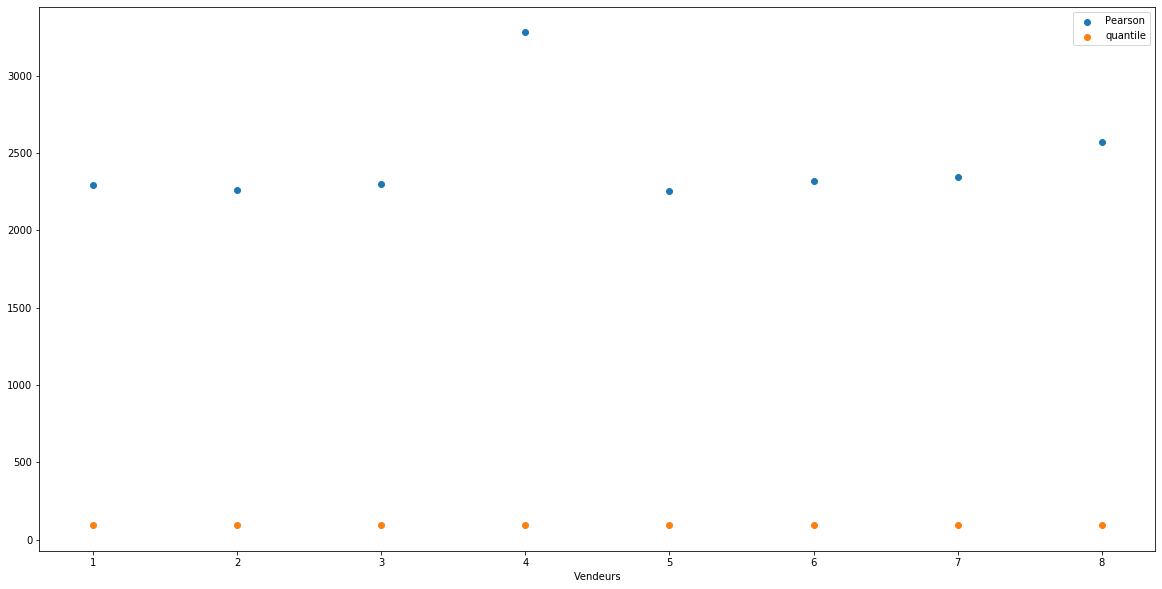

Vendeur 1 : coupable
Vendeur 2 : coupable
Vendeur 3 : coupable
Vendeur 4 : coupable
Vendeur 5 : coupable
Vendeur 6 : coupable
Vendeur 7 : coupable
Vendeur 8 : coupable


In [204]:
Pearson_test(ref_1,0.0000000000000001, 1)

La statistique de Person est très grande donc la logique du test consiste à rejetter l'hypothèse nulle pour chaque vendeur, ce qui correspond à rejetter l'égalité en loi. 

Ce test ne semble pas tout à fait adapter pour distinguer les innocents des coupables. Par ailleurs, tester uniquement l'adéquation de la loi du premier chiffre significatif peut sembler un peu léger pour rechercher des fraudes. Une possibilité est de regarder ce qui se passe au niveau du deuxième chiffre significatif.

### 2.2 Loi du deuxième chiffre significatif : test du $\chi^{2}$

Le deuxième chiffre significatif, noté $C_{2}$ peut être calculé à partir de $T$ de la manière suivante : $C_{2}=\lfloor 10 \operatorname{Frac}(T)\rfloor$. On peut montrer que sa loi est
$$
\forall k \in\{0,9\}, \mathbb{P}\left(C_{2}=k\right)=\sum_{d=1}^{9} \log \left(1+\frac{1}{10 d+k}\right)
$$
Notée loi $(3)$

Le test du $\chi^{2}$ correspondant peut s'écrire de la manière suivante. 
- $H_{0}^{(2)}:$ le deuxième chiffre suit la loi $(3)$ 
* $H_{1}^{(2)}:$ le deuxième chiffre ne suit pas la loi $(3)$. 

Pour $k \in\{0, \ldots, 9\}$, on note $N_{k}^{(2)}$ le nombre de données dont le deuxième chiffre significatif est $k$. On définit la statistique de test dans ce cas par
$$
D_{N}^{(2)}=\sum_{k=0}^{9} \frac{\left(N_{k}^{(2)}-N \mathbb{P}\left(C_{2}=k\right)\right)^{2}}{N \mathbb{P}\left(C_{2}=k\right)}
$$
On sait alors que, sous $H_{0}^{(2)}$,
$$
D_{N}^{(2)} \underset{N \rightarrow+\infty}{\stackrel{\mathcal{L}}{\longrightarrow}} \chi_{9}^{2}
$$
De plus, sous $H_{1}^{(2)}$
$$
D_{N}^{(2)} \underset{N \rightarrow+\infty}{\stackrel{\mathrm{p.s.}}{\longrightarrow}}+\infty
$$

In [124]:
ref_2 = np.array( [ np.sum(np.array([np.log(1+1/(10*d+k))/np.log(10) for d in range(1,10)])) for k in range(10)])
print(ref_2)

[0.11967927 0.1138901  0.1088215  0.10432956 0.1003082  0.09667724
 0.09337474 0.09035199 0.08757005 0.08499735]


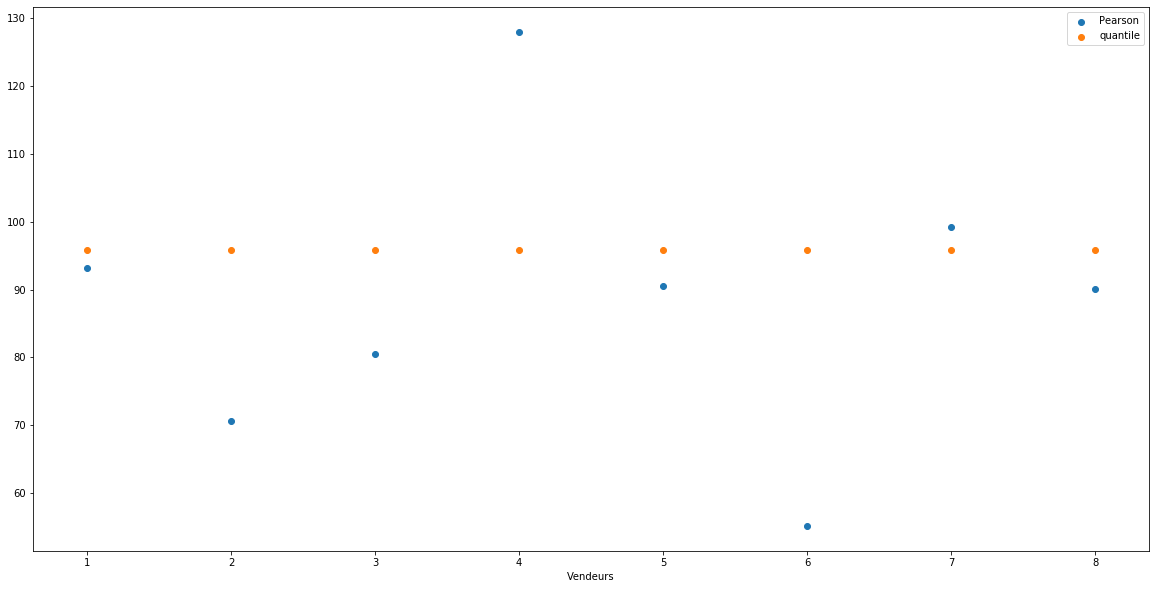

Vendeur 1 : innocent
Vendeur 2 : innocent
Vendeur 3 : innocent
Vendeur 4 : coupable
Vendeur 5 : innocent
Vendeur 6 : innocent
Vendeur 7 : coupable
Vendeur 8 : innocent


In [208]:
Pearson_test(ref_2, 0.0000000000000001, 2)

Ce test est plus concluant, avec une grande précision, il semblerait que le vendeur 4 et 7 aient des choses à se repprocher, je vous propose de creuser la question sous un autre angle en étudiant un test de Kolmogorov-Smirnov.

### 2.3 Loi de la mantisse : test de Kolmogorov-Smirnov

Une autre stratégie, assez différente, consiste à tester directement l'adéquation de la loi de $T$ à la loi de Benford (définition 1). Pour cela, le chef d'entreprise envisage d'utiliser un autre test, le test de Kolmogorov-Smirnov, qui utilise la fonction de répartition empirique.
- $H_{0}^{(3)}:$ la mantisse suit la loi de Benford. 
- $H_{1}^{(3)}:$ la mantisse ne suit pas la loi de Benford.

On note $F_{B}$ la fonction de répartition de la loi de Benford et $F_{N}$ la fonction de répartition empirique des données, notées $\left(T_{1}, \ldots, T_{N}\right)$.
$$
\forall x \in \mathbb{R}, F_{N}(x)=\frac{1}{N} \sum_{k=1}^{N} 1_{T_{k} \leqslant x}
$$
Sous $H_{0}^{(3)}$, on a alors le résultat suivant.
$$
\sqrt{N} \sup _{x \in \mathbb{R}}\left|F_{N}(x)-F_{B}(x)\right| \underset{N \rightarrow+\infty}{\stackrel{\mathcal{L}}{\longrightarrow}} K S
$$
où $K S$ est la loi de Kolmogorov-Smirnov. Cette loi est indépendante de la loi des données et peut donc être tabulée en simulant $\sqrt{N} \sup _{x \in \mathbb{R}}\left|F_{U_{N}}(x)-F_{U}(x)\right|$ pour des variables aléatoires
i.i.d. $\left(U_{N}\right)_{N \in \mathbb{N}}$ et $U$ de loi uniforme sur $[0,1] .$ Sous $H_{1}^{(3)}$, cette même quantité tend presque surement vers $+\infty$

Nous allons montrer que la loi de $\sqrt{n} \sup_{x \in \mathbb{R}} \left| F_{N}(x)-F(x) \right|$ ne dépend pas de la loi des données. Puisque $T_{1}$ et $F_{B}^{(-1)}(U)$ ont la même loi lorsque $U$ est un variable aléatoire de loi $\mathcal{U}([0,1])$. Posons alors $U_{1},...,U_{N}$ indépendantes de loi $\mathcal{U}([0,1])$ on a 

\begin{align*}
\sup_{x \in \mathbb{R}} \left| F_{N}(x)-F_{B}(x) \right| 
&= \sup_{x \in \mathbb{R}} \left| {1 \over N } \sum_{j=1}^{N} \mathbb{1}_{T_{k} \le x}-F_{B}(x) \right| \\
&= \sup_{x \in \mathbb{R}} \left| {1 \over N } \sum_{j=1}^{N} \mathbb{1}_{F^{(-1)}_{B}(U_{k}) \le x}-F_{B}(x) \right|  \\
&= \sup_{x \in \mathbb{R}} \left| {1 \over N } \sum_{j=1}^{N} \mathbb{1}_{U_{k} \le F_{B}(x)}-F_{B}(x) \right|  \\
&= \sup_{x \in [0;1]} \left| {1 \over N } \sum_{j=1}^{N} \mathbb{1}_{U_{k} \le t}-t \right|  \\
\end{align*}
On a utilise deux fois que $F_{B}$ est une bijection de $[1;10] \rightarrow [0;1]$ d'inverse $F_{B}^{(-1)}$, voir son expression en partie 1.

In [215]:
def F_rep_emp(sample_sort, t):
    """
    Return la fonction de répartition empirique d'un échantillon trié
    """
    res = 0
    while res < np.size(sample_sort) and sample_sort[res]<=t :
        res = res+1
    return res/np.size(sample_sort)

In [132]:
# test
print(F_rep_emp(np.sort([1,2,3,4,5]),4))
print(F_rep_emp(np.sort([1,2,3,4,5]),6))
print(F_rep_emp(np.sort([1,2,3,4,5]),-1))

0.8
1.0
0.0


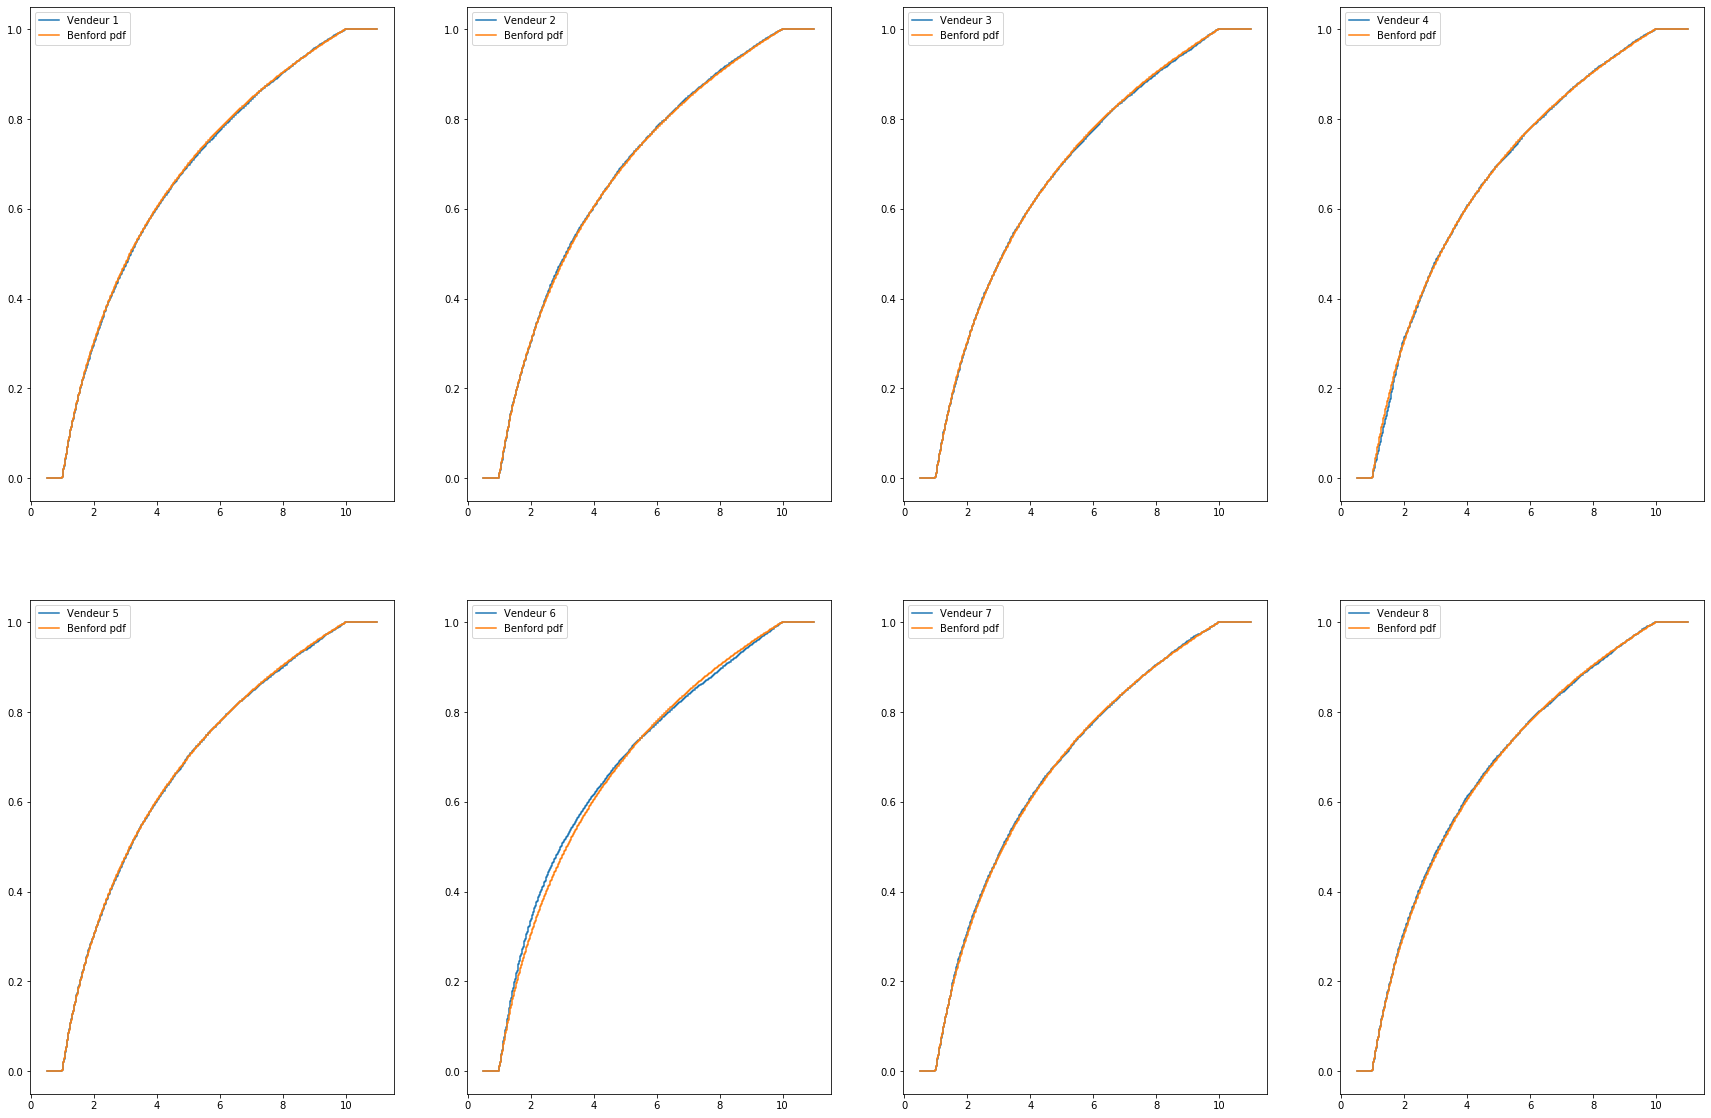

In [144]:
fig_emp,axs_emp = plt.subplots(2,4, figsize = [30,20])  
vendeur_emp = 1
X_emp = np.linspace(0.5,11, 500)
for l in range(2):
    for c in range(4):
        V_sort = np.sort(V[vendeur_emp-1])
        axs_emp[l][c].step(X_emp, np.array([F_rep_emp(V_sort,x) for x in X_emp]), label = "Vendeur {}".format(vendeur_emp))
        axs_emp[l][c].step(X_emp, np.array([Benford_rep(x) for x in X_emp]), label ="Benford pdf" )
        axs_emp[l][c].legend()
        vendeur_emp = vendeur_emp +1
plt.show()

Les fonctions de répartitions empirique semblent très proches de la fonction de répartiton de la loi de Benford pour s'en assurer un peu plus traçons $|F_{n}(x) -F(x)|$

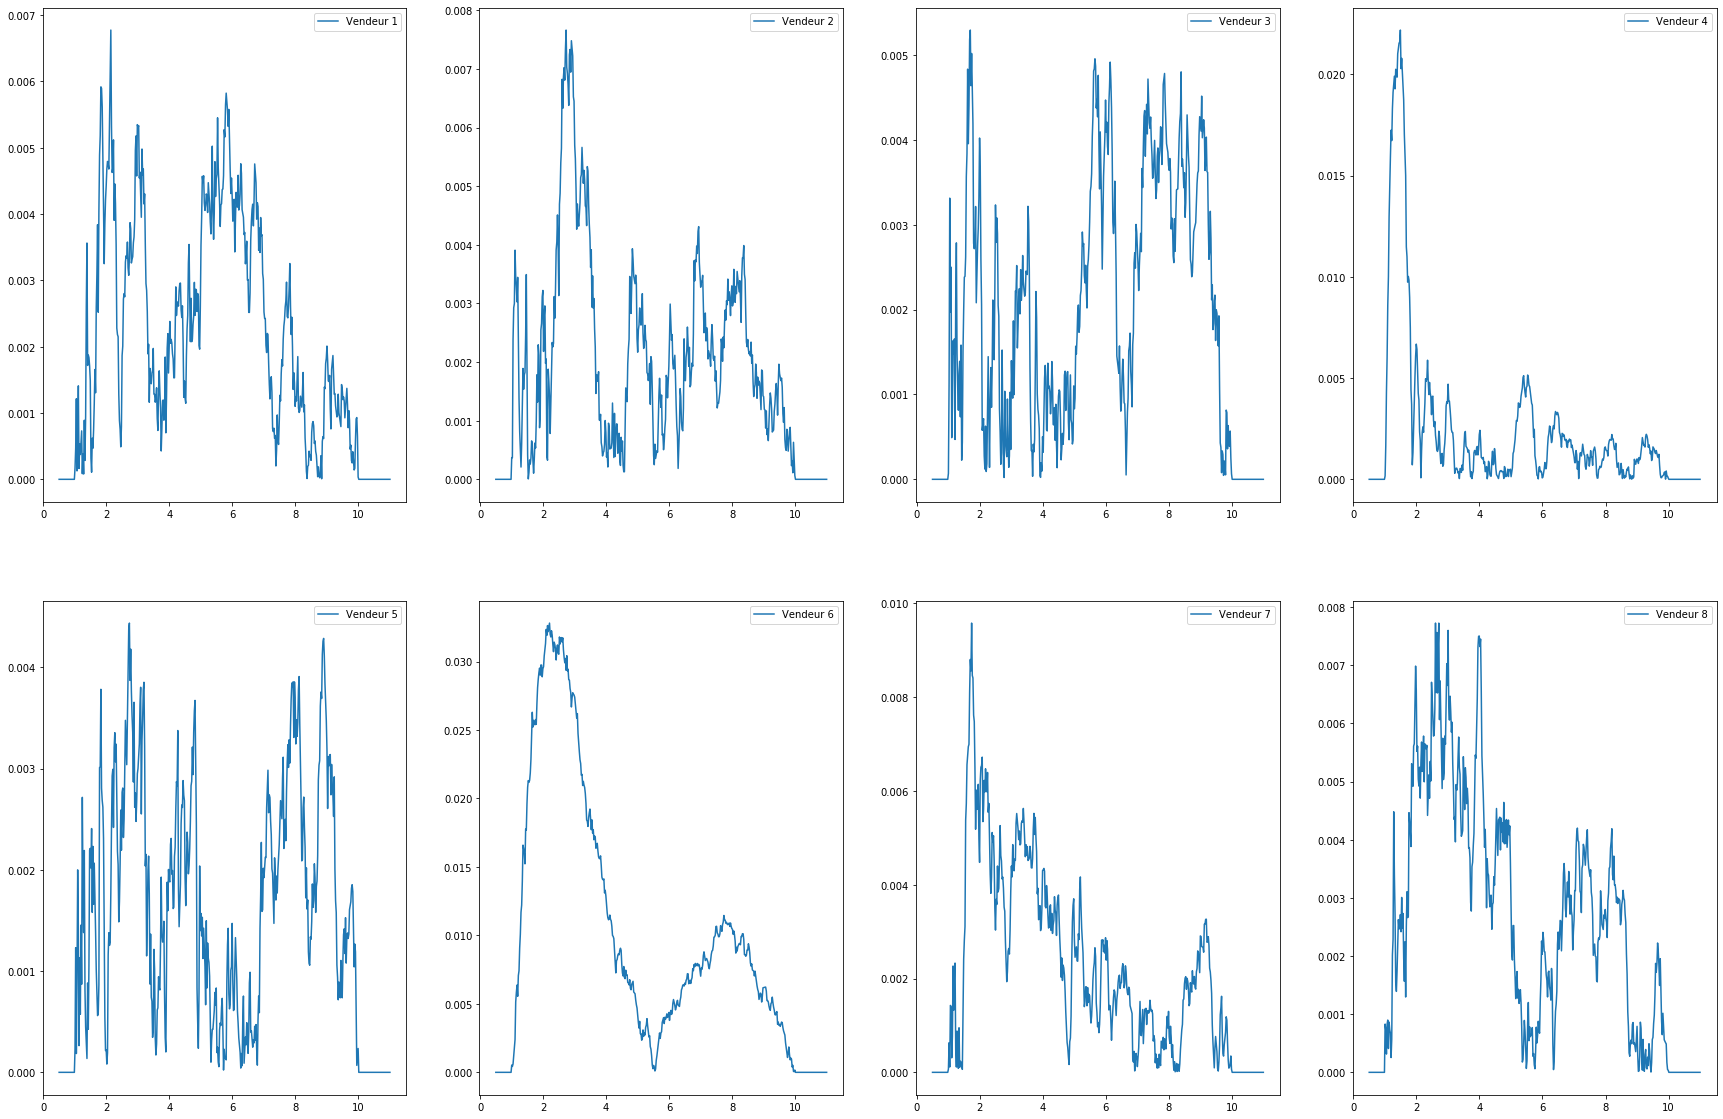

In [146]:
fig_emp,axs_emp = plt.subplots(2,4, figsize = [30,20])  
vendeur_emp = 1
X_emp = np.linspace(0.5,11, 500)
for l in range(2):
    for c in range(4):
        V_sort = np.sort(V[vendeur_emp-1])
        axs_emp[l][c].plot(X_emp, np.array([ np.abs(F_rep_emp(V_sort,x) - Benford_rep(x) ) for x in X_emp]), 
                           label = "Vendeur {}".format(vendeur_emp))
        axs_emp[l][c].legend()
        vendeur_emp = vendeur_emp +1
plt.show()

Regardons maintenant une approximation (discrétisation) de la norme sup.

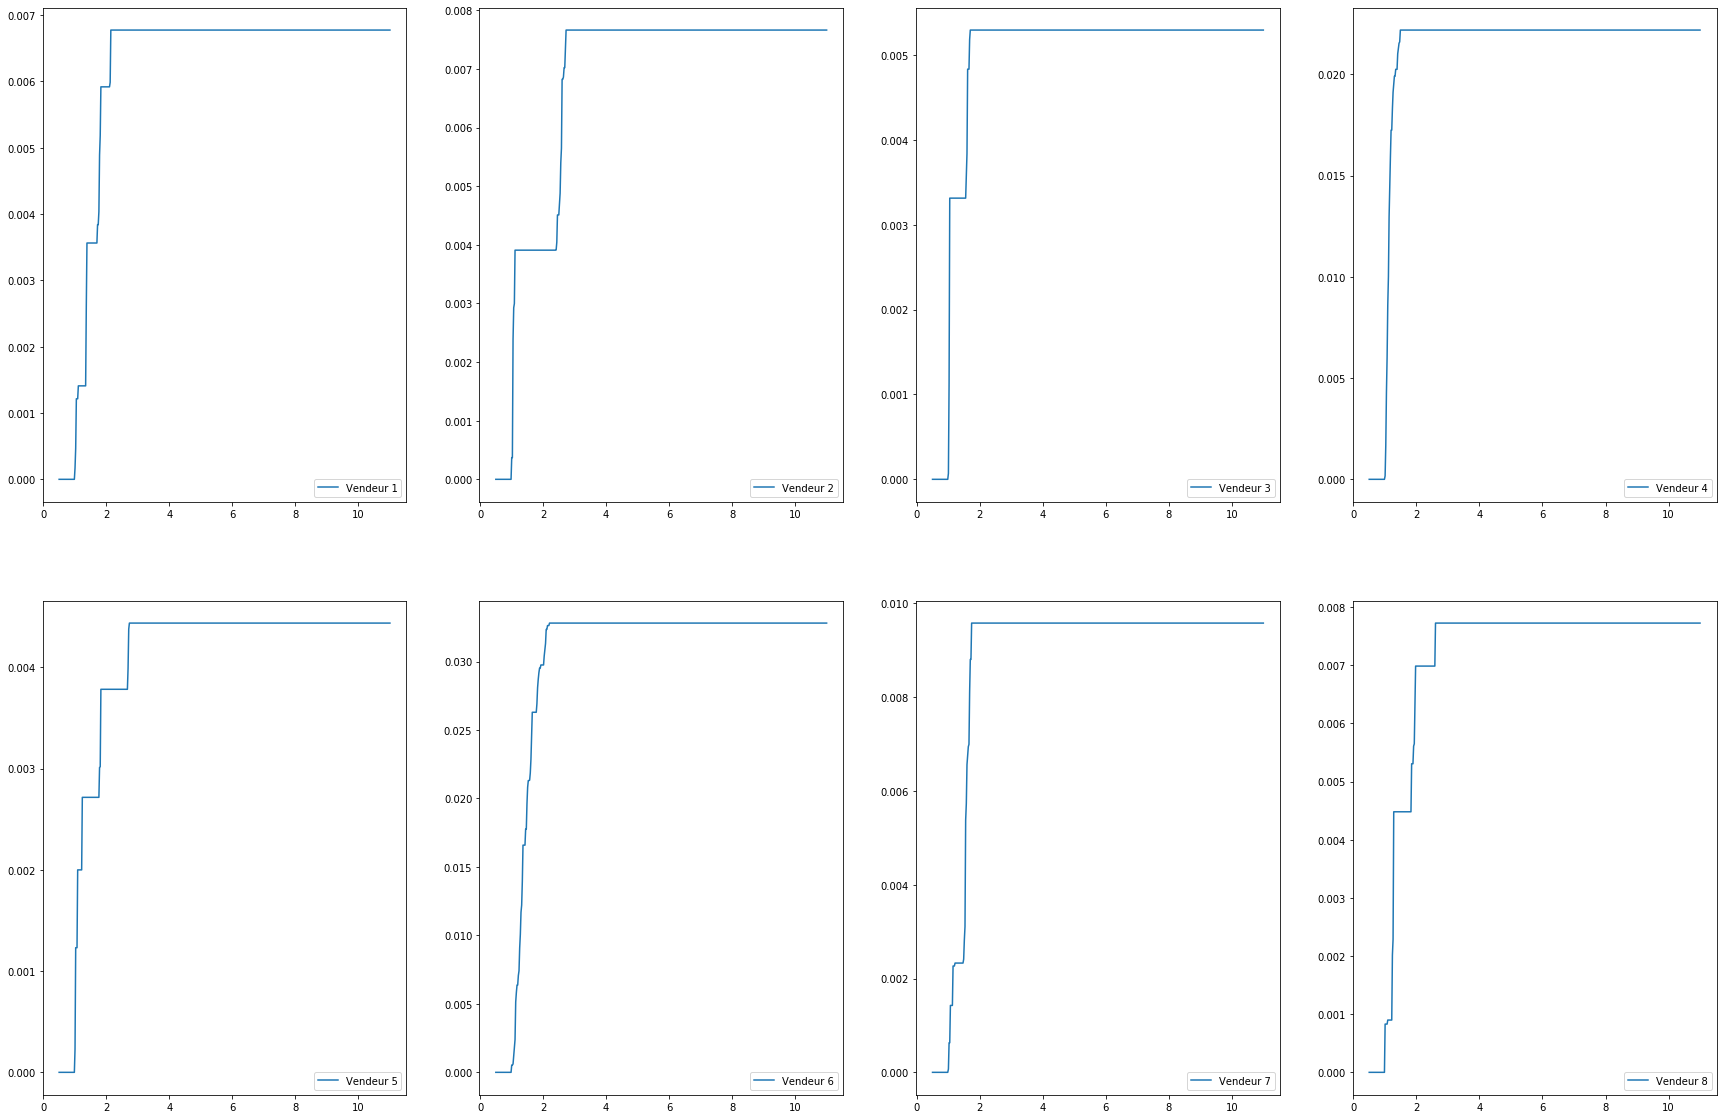

In [161]:
fig_emp,axs_emp = plt.subplots(2,4, figsize = [30,20])  
vendeur_emp = 1
Size_emp = 500
X_emp = np.linspace(0.5,11, Size_emp)
for l in range(2):
    for c in range(4):
        V_sort = np.sort(V[vendeur_emp-1])
        sup = np.zeros(Size_emp)
        sup[0] = np.abs(F_rep_emp(V_sort,X_emp[0]) - Benford_rep(X_emp[0]))
        for i in range(1,Size_emp):
            actual_emp = np.abs(F_rep_emp(V_sort,X_emp[i]) - Benford_rep(X_emp[i]))
            if actual_emp > sup[i-1]:
                      sup[i] =actual_emp
            else:
                                sup[i] = sup[i-1]
        axs_emp[l][c].plot(X_emp, sup, label = "Vendeur {}".format(vendeur_emp))
        axs_emp[l][c].legend()
        vendeur_emp = vendeur_emp +1
plt.show()

On voit que le sup est 3 fois plus élevé chez le vendeur $6$. Maintenant on peut passer au test en lui même.

Pour tester $\mathrm{H}_{0}:$ l'échantillon est bien issu d'une loi $F_{0}$ contre $\mathrm{H}_{1}:$ l'échantillon n'est pas issu d'une loi $F_{0}$ on considère $D_{n}$ défini avec $F=F_{0}:$
$$
D_{n}=\sup _{x \in \mathbb{R}}\left|\hat{F}_{n}(x)-F_{0}(x)\right|
$$
Alors sous $\mathrm{H}_{0},$ la suite $\sqrt{n} D_{n}$ va tendre vers une loi de Kolmogorov-Smirnov et sous $\mathrm{H}_{1},$ comme $\hat{F}_{n} \rightarrow F \neq 0$ on a $D_{n} \leftrightarrow 0,$ donc $\sqrt{n} D_{n} \rightarrow \infty$ presque-
surement. On va donc rejeter $\mathrm{H}_{0}$ si l'on observe des valeurs trop grandes pour
$\sqrt{n} D_{n}:$ la zone de rejet est de la forme $\left[\sqrt{n} D_{n}>K_{1-\alpha}\right]$ où $K_{1-\alpha}$ est le quantile d'ordre $1-\alpha$ de la loi de Kolmogorov-Smirnov.

In [162]:
def Kolmogorov_stat(sample_sort):
    """
    """
    n = np.size(sample_sort)
    max_i = lambda i : np.max(np.array( [ i/n - Benford_rep(sample_sort[i-1]), Benford_rep(sample_sort[i-1]) - (i-1)/n] ) ) 
    return np.max( np.array([ max_i(i) for i in range(1,n+1)]))

In [230]:
def Kolmogorov_test(alpha):
    """
    
    """
    q = st.kstwobign().ppf(1-alpha)
    N = np.arange(1,9)
    Kolmogorov_stat_all = np.sqrt(1000)*np.array([Kolmogorov_stat(np.sort(V[i])) for i in range(8)])
    plt.figure(figsize = [20,10])
    plt.scatter(N,Kolmogorov_stat_all, label = "Kolmogorov")
    plt.scatter(N,[q]*8, label = "quantile")
    plt.xlabel("Vendeurs")
    plt.legend()
    plt.show()
    for i in range(8):
        if Kolmogorov_stat_all[i] <= q:
            print("Vendeur {} : Innocent".format(i+1))
        else:
            print("Vendeur {} : Coupable".format(i+1))

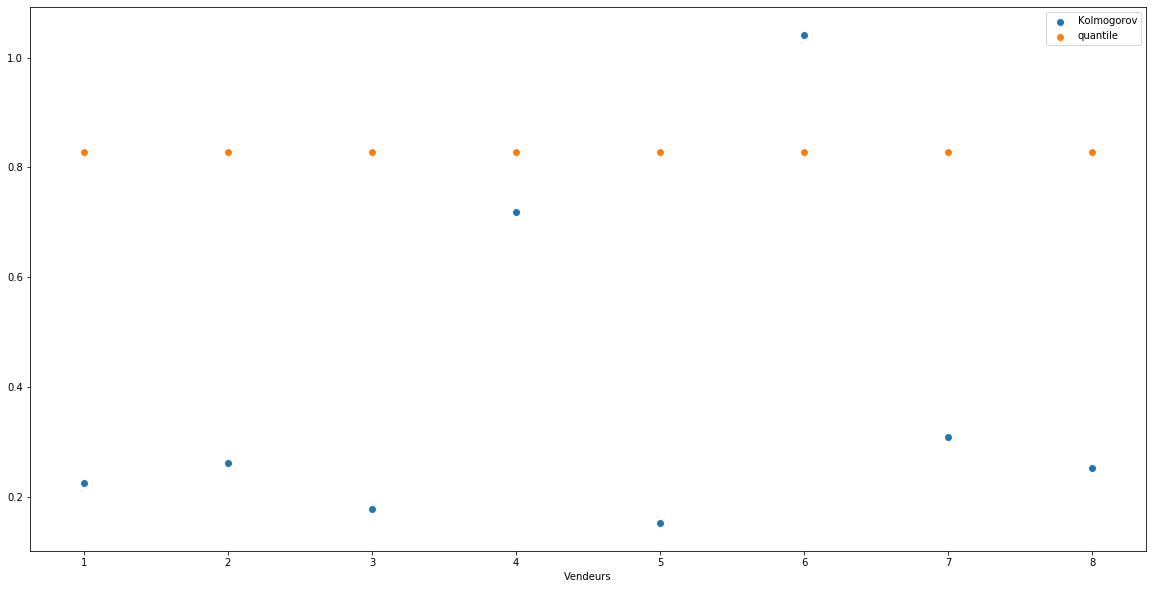

Vendeur 1 : Innocent
Vendeur 2 : Innocent
Vendeur 3 : Innocent
Vendeur 4 : Innocent
Vendeur 5 : Innocent
Vendeur 6 : Coupable
Vendeur 7 : Innocent
Vendeur 8 : Innocent


In [233]:
Kolmogorov_test(0.5)

**Conclusion** : Il me reste à affiner le test de Kolmogorov, j'ai n'ai pas eu le temps d'en tirer des conclusions, en attendant vendeur 4 et 7 dans mon bureau !!!